In [100]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML


# some Jupyter initilizations
# Visualizations will be shown in the notebook.
%matplotlib inline

chess_dimensions = (9,6)

# some easy references
calibration_images_location = glob.glob('./camera_cal/calibration*.jpg')
test_images_location = glob.glob('./test_images/*.jpg')

In [101]:
######## CAMERA CALIBRATION
def calibrateCamera(imageLocations, debug=False):
    objpoints = []
    imgpoints = []
    # Define the object points in 3D
    objp = np.zeros((chess_dimensions[0]*chess_dimensions[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:chess_dimensions[0],0:chess_dimensions[1]].T.reshape(-1,2)

    # process all images
    for imageLocation in imageLocations:
        # read the image
        image = mpimg.imread(imageLocation)
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, chess_dimensions, None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            if debug:
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 12))
                f.tight_layout()
                ax1.imshow(image)
                ax1.set_title('Original Image', fontsize=50)
                ax2.imshow(cv2.drawChessboardCorners(image, chess_dimensions, corners, ret))
                ax2.set_title('Chessboard Corners', fontsize=50)
    
    # calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

def undistort(image, camera_matrix, dist_coeff):
    undistorted = cv2.undistort(image, camera_matrix, dist_coeff)
    return undistorted

In [102]:
# Cell containing all logic to compute a thresholded binary image
def abs_sobel_thresh(gray_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(gray_img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(gray_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def threshold_binary(image, debug=False):
    # convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # S channel is the preferred one
    S = hls[:,:,2]
    # binary image
    thresh = (170, 255)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    if(debug):
        plt.figure(figsize=(14,14))
        plt.imshow(binary, cmap='gray')
        plt.title('HLS S-Color Threshold', fontsize=20)
    
    # generate others
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    sobelx = abs_sobel_thresh(gray, 'x', sobel_kernel=3, thresh=(20, 100))
    
    combined_binary = np.zeros_like(sobelx)
    combined_binary[(binary == 1) | (sobelx == 1)] = 1
    return combined_binary;

def perspectiveTransform(image, debug=False):
    # TODO: remove
    # detect the perspective points
    img_size = (image.shape[1], image.shape[0])
    src = np.float32([[200,img_size[1]],[595,450],[690,450],[1120,img_size[1]]])
    dst = np.float32([[200,img_size[1]],[200,0],[1000,0],[1000,img_size[1]]])
    # TODO: persist this transformation so it can be reused later on without recalculating it over again
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    if(debug):
        # source
        pts = np.array([[200,img_size[1]],[590,450],[690,450],[1120,img_size[1]]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(image, [pts], True, (0,0,255), thickness=5)
        # target
        pts = np.array([[200,img_size[1]],[200,0],[1000,0],[1000,img_size[1]]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(warped, [pts], True, (0,0,255), thickness=5)
        print('Source points: ', src)
        print('Target points: ', dst)
    return M, Minv, warped;

In [106]:
def line_finding_histogram(binary_warped, debug=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
  
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    if debug:
        print(left_curverad, right_curverad)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    if debug:
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m
        
    # Camera position
    car_center = right_fitx[-1] - left_fitx[-1]
    lane_center = 660 #binary_warped.shape[1] / 2.
    car_location_to_center = (lane_center-car_center) * xm_per_pix

    # debugging?
    if debug:
        print( 'car_center:', car_center)
        print( 'lane_center:', lane_center)
        print( 'car_location_to_center:', car_location_to_center)
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return ploty, left_fitx, right_fitx, left_curverad, car_location_to_center;

def draw_on_image(img, ploty, left_fitx, right_fitx, Minv, curvature, from_center):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Curvature text
    cv2.putText(result, "Curvature: {}m".format(int(curvature)), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    cv2.putText(result, "From Center: {0:.3f}".format(from_center), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    return result

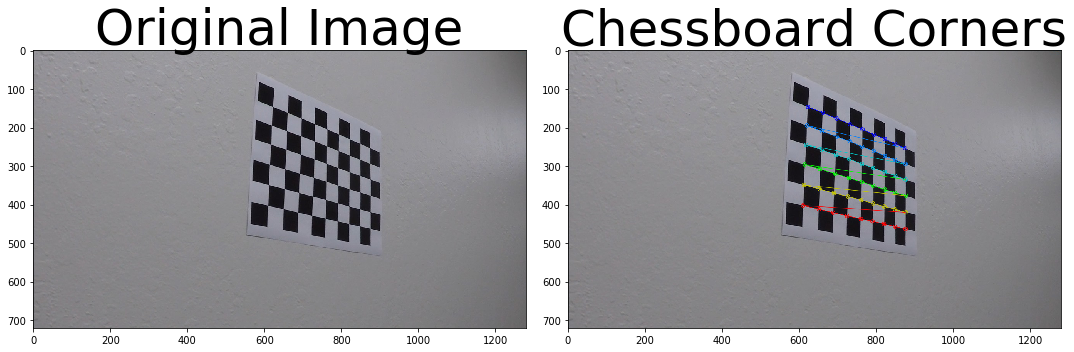

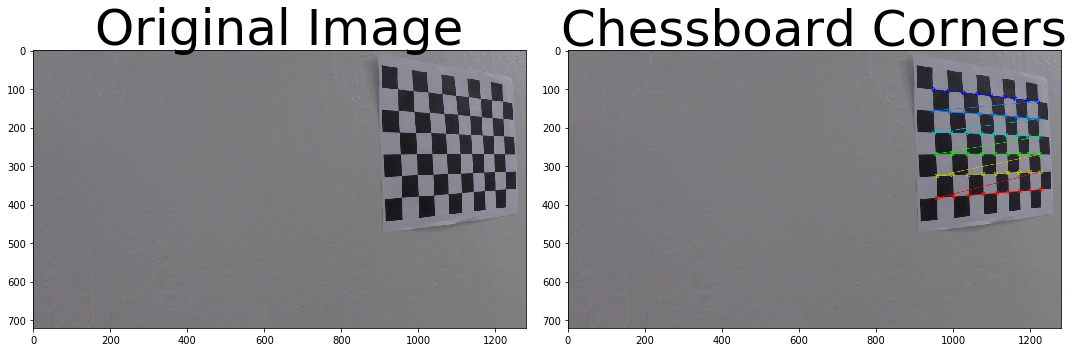

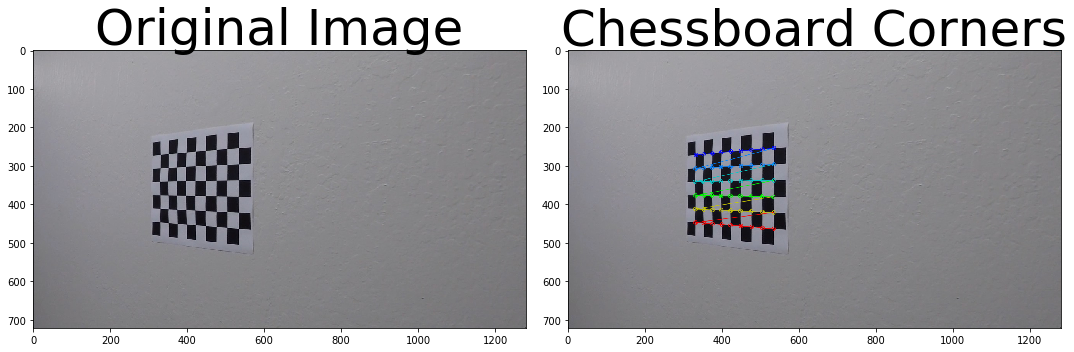

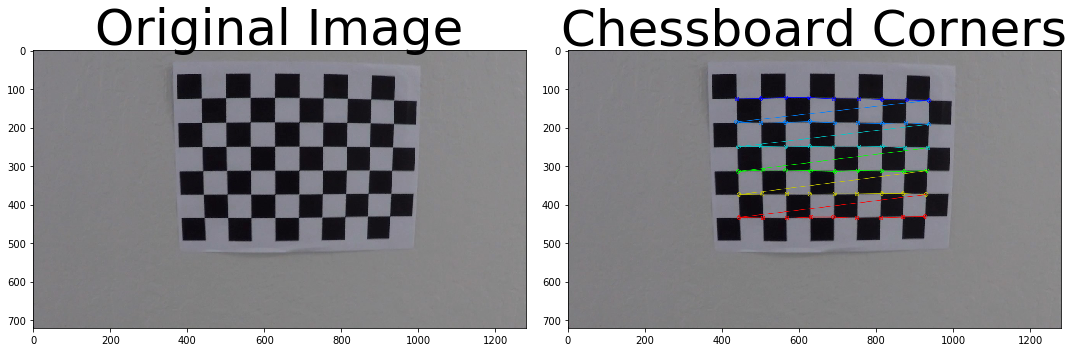

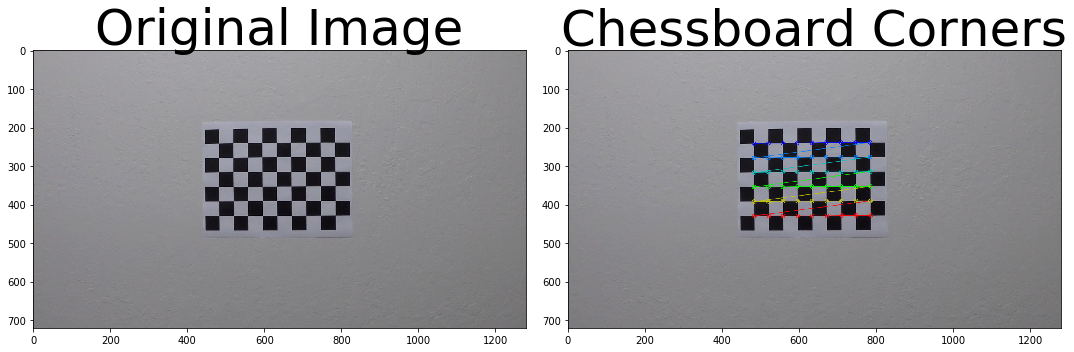

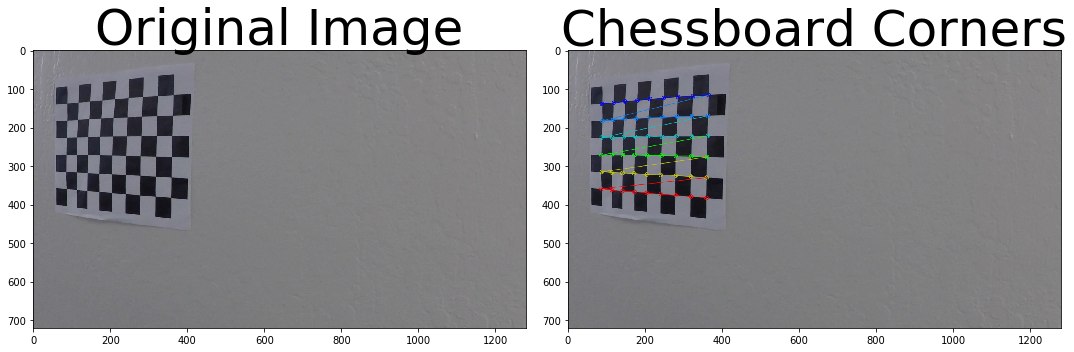

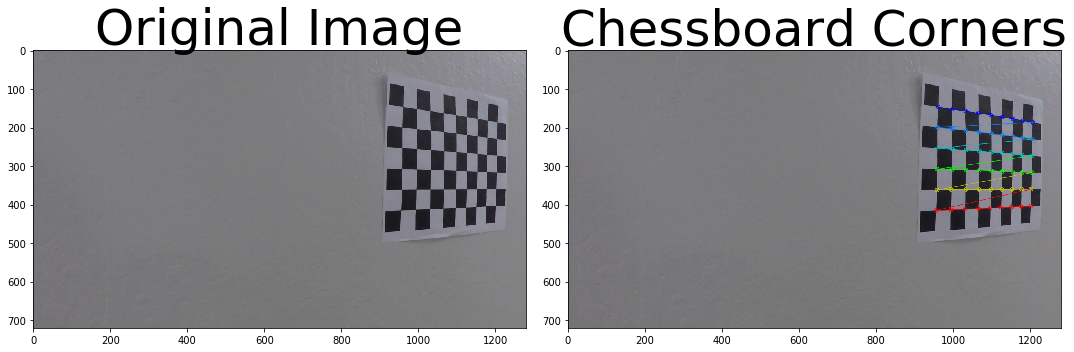

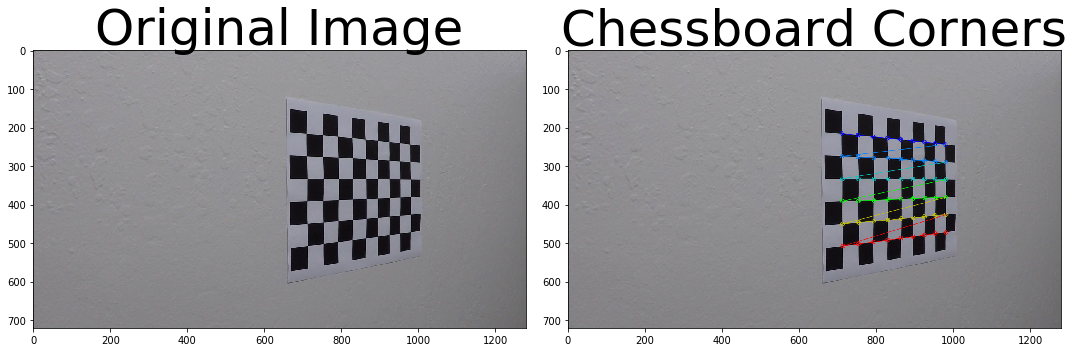

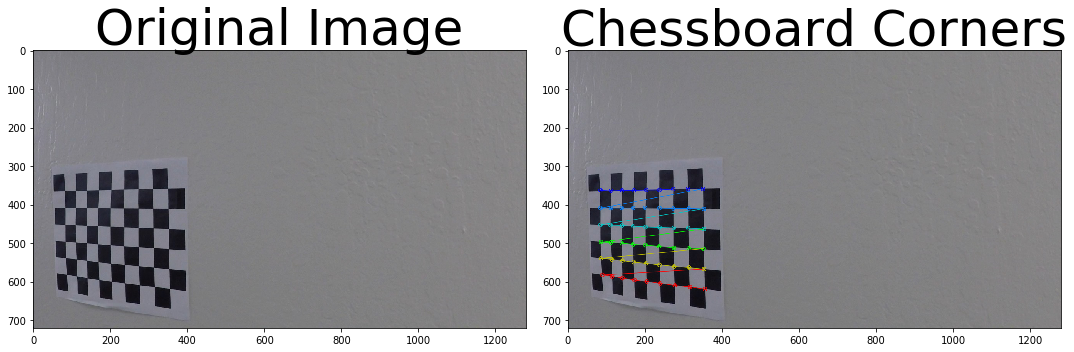

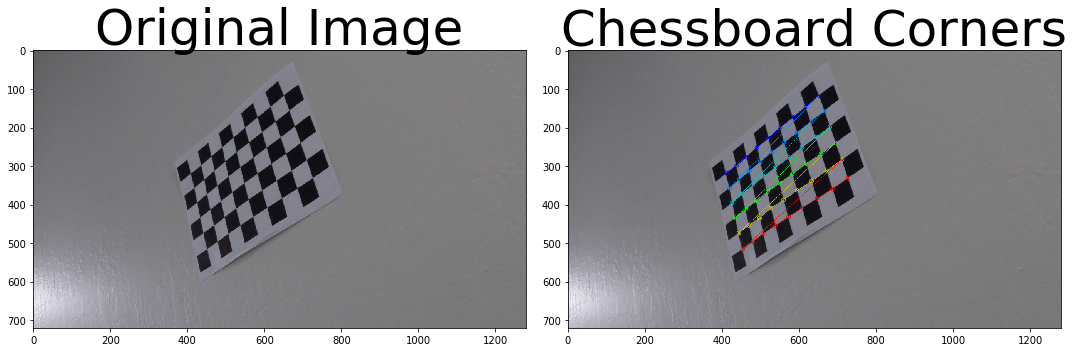

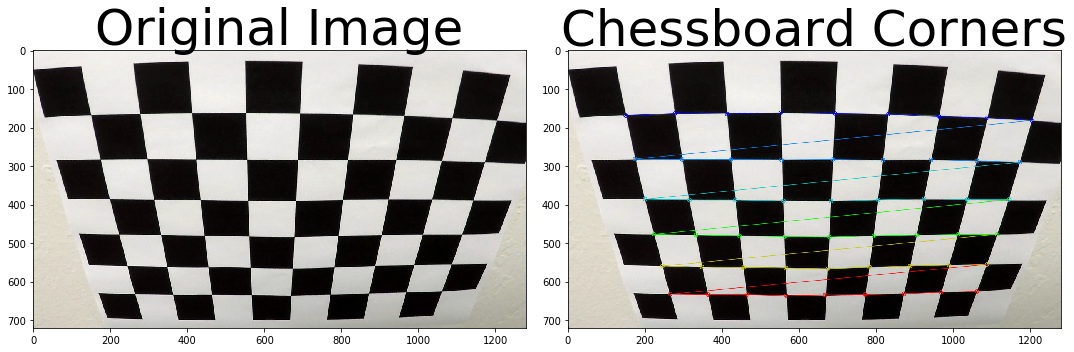

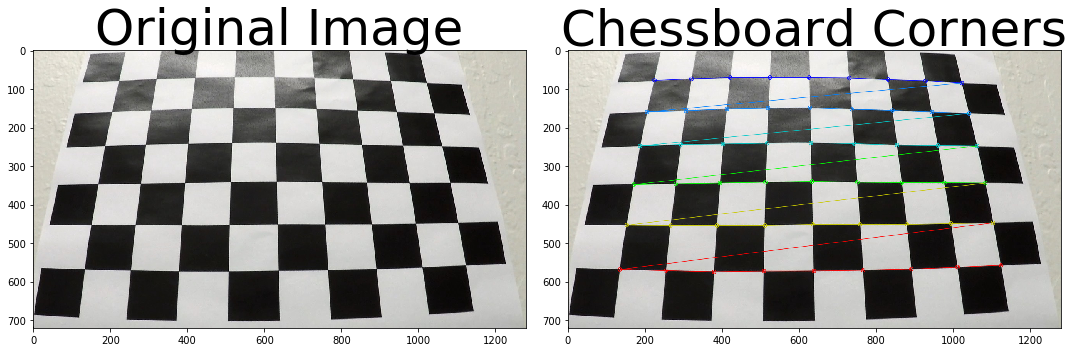

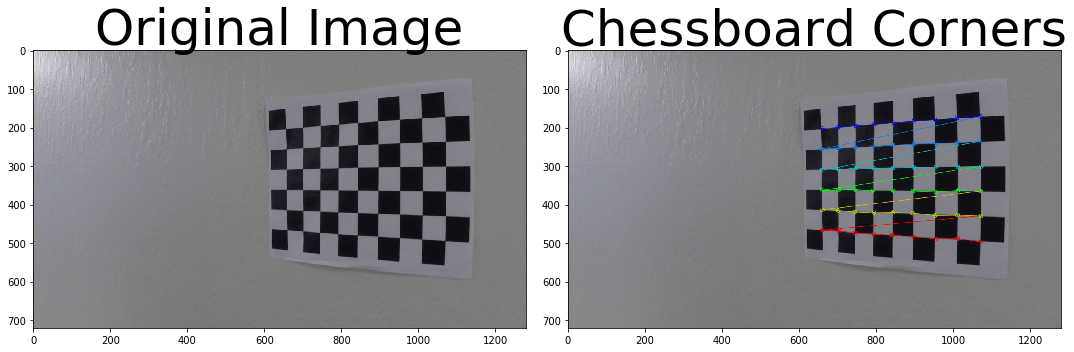

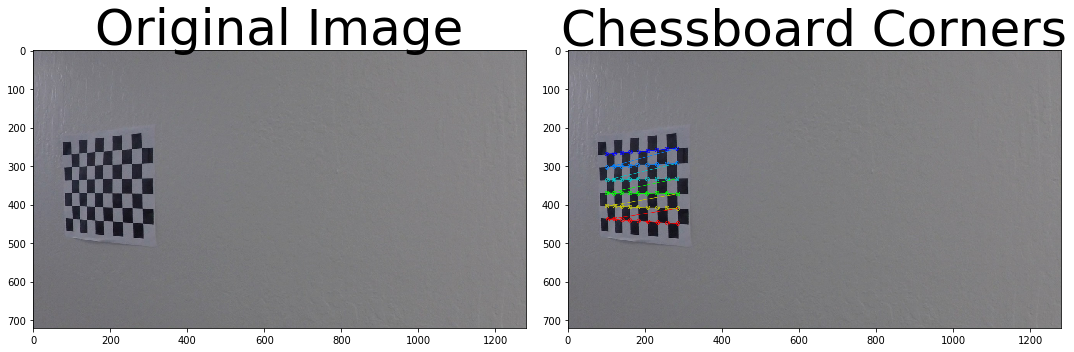

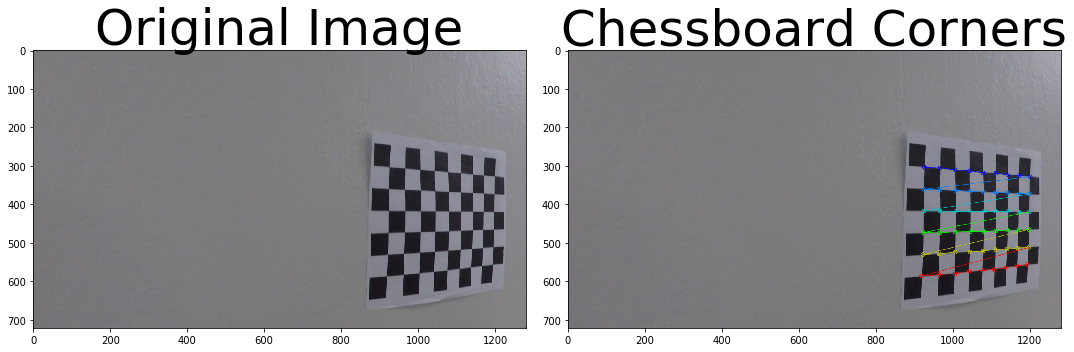

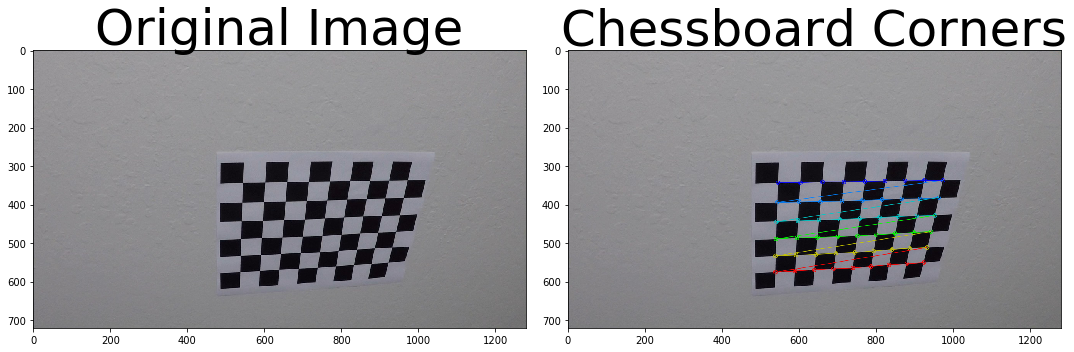

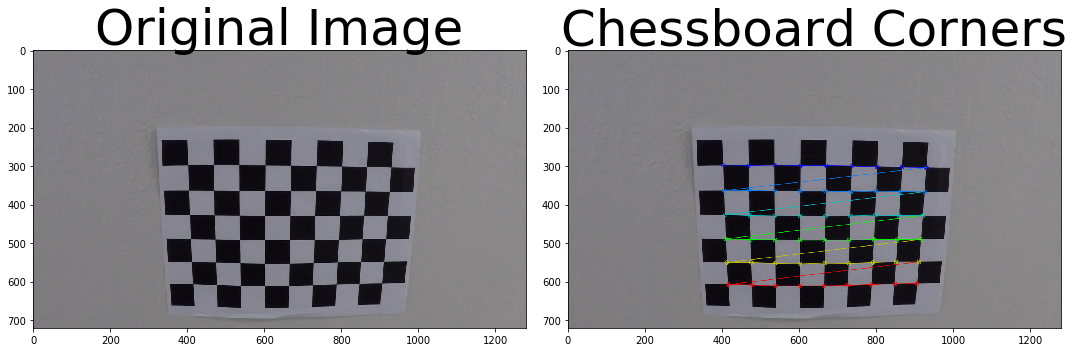

In [104]:
# Logic:
# 1. calibrate the camera
mtx, dist = calibrateCamera(calibration_images_location, debug=True)

1088.02022167 831.166557706
357.190428754 m 270.496897117 m
car_center: 749.638446705
lane_center: 660
car_location_to_center: -0.473803218298


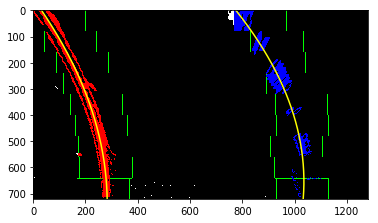

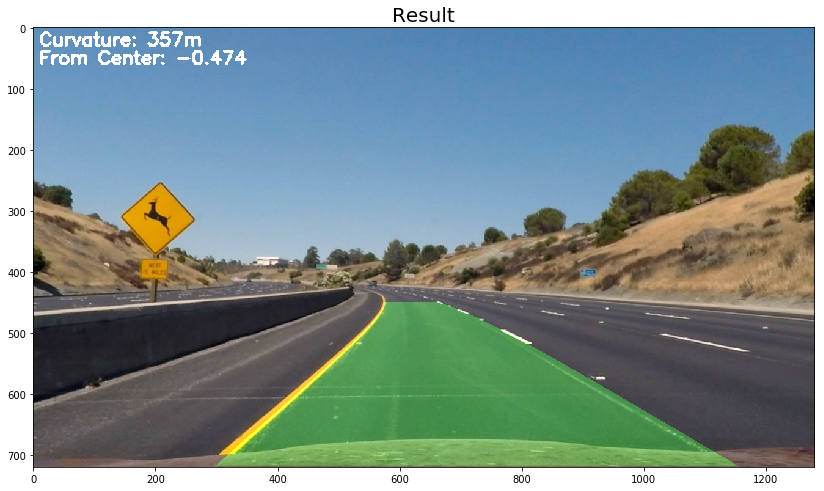

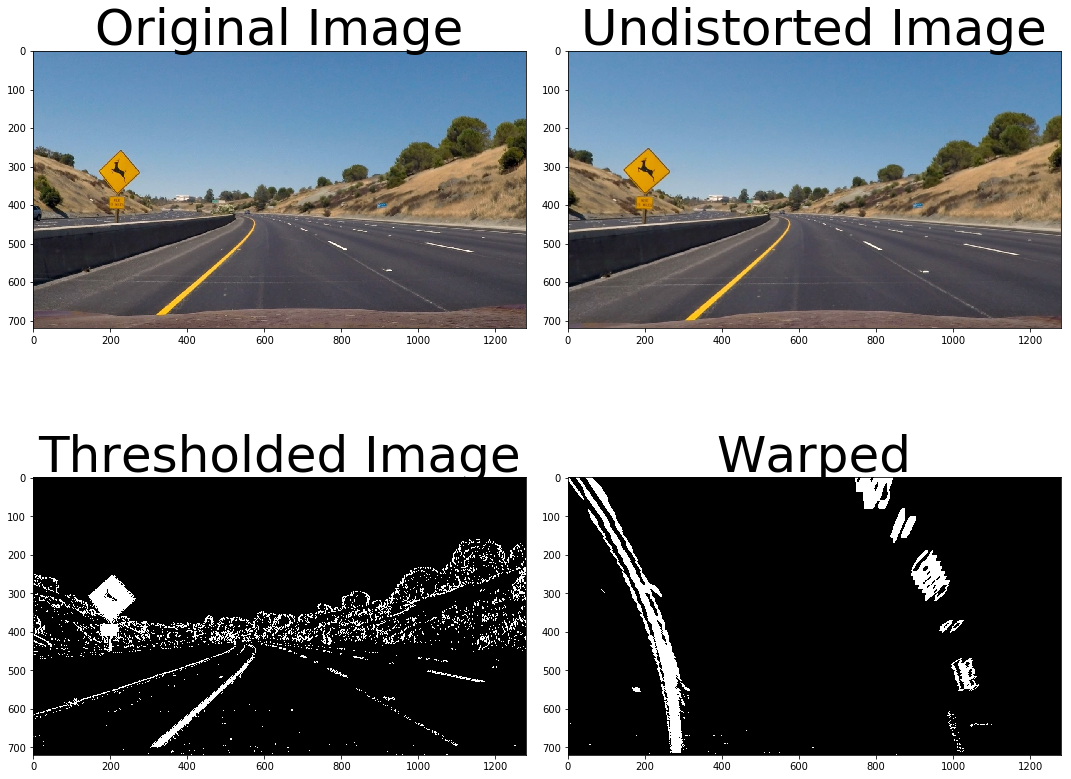

In [107]:
# read the image
#image = mpimg.imread('./test_images/straight_lines2.jpg')
image = mpimg.imread('./test_images/test2.jpg')
# undistort
undistorted = undistort(image, mtx, dist)
# Apply the thresholing pipeline
thresholded = threshold_binary(undistorted)
# Perform perspective transformation
M, Minv, warped = perspectiveTransform(thresholded)

# Method 1 line finding
ploty, left_fitx, right_fitx, curvature, cam_pos = line_finding_histogram(warped, True)
# and draw on the original image
result = draw_on_image(undistorted, ploty, left_fitx, right_fitx, Minv, curvature, cam_pos)
plt.figure(figsize=(14,14))
plt.imshow(result)
plt.title('Result', fontsize=20)


# and show the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(thresholded, cmap='gray')
ax3.set_title('Thresholded Image', fontsize=50)
ax4.imshow(warped, cmap='gray')
ax4.set_title('Warped', fontsize=50)

In [ ]:
def process_image(image):
    # undistort
    undistorted = undistort(image, mtx, dist)
    # Apply the thresholing pipeline
    thresholded = threshold_binary(undistorted)
    # Perform perspective transformation
    M, Minv, warped = perspectiveTransform(thresholded)

    # Method 1 line finding
    ploty, left_fitx, right_fitx, curvature, cam_pos = line_finding_histogram(warped, False)
    # and draw on the original image
    return draw_on_image(undistorted, ploty, left_fitx, right_fitx, Minv, curvature, cam_pos)

### The video image
annotated_video = "project_video_annotated.mp4"
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(annotated_video, audio=False)

In [ ]:
# play the generated image
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(annotated_video))

Original image:  ./test_images/straight_lines2.jpg
Source points:  [[  200.   720.]
 [  595.   450.]
 [  690.   450.]
 [ 1120.   720.]]
Target points:  [[  200.   720.]
 [  200.     0.]
 [ 1000.     0.]
 [ 1000.   720.]]


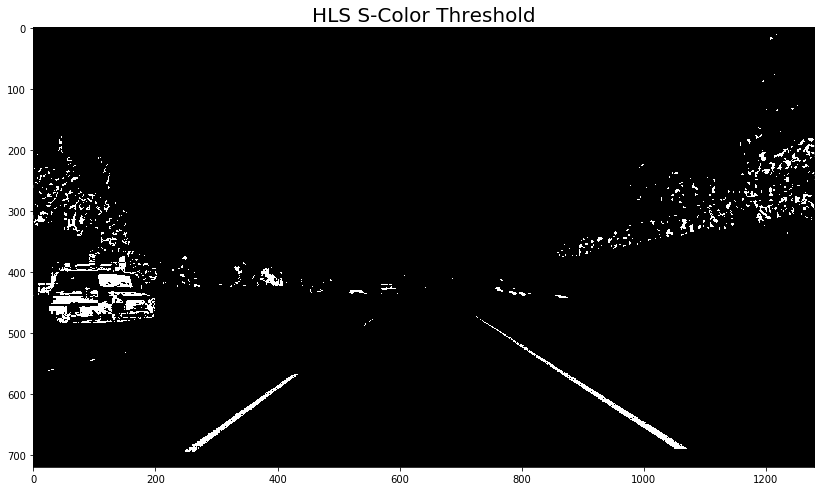

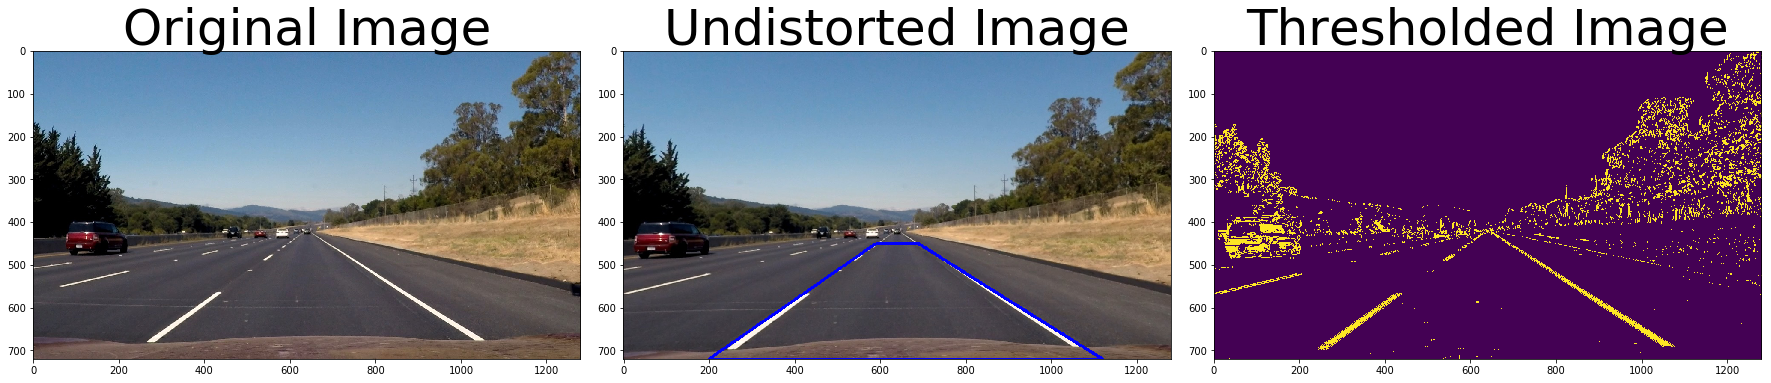

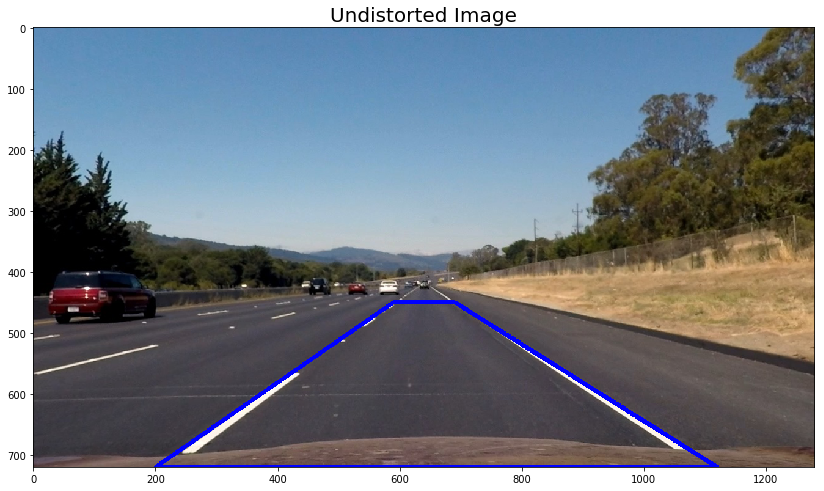

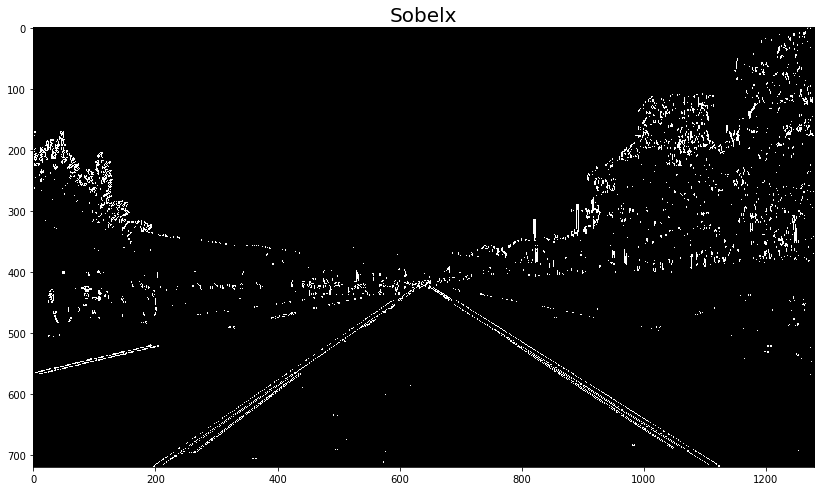

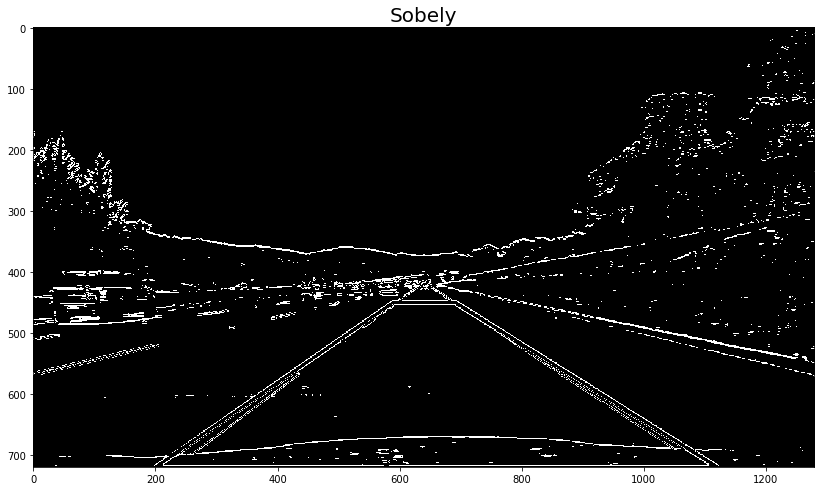

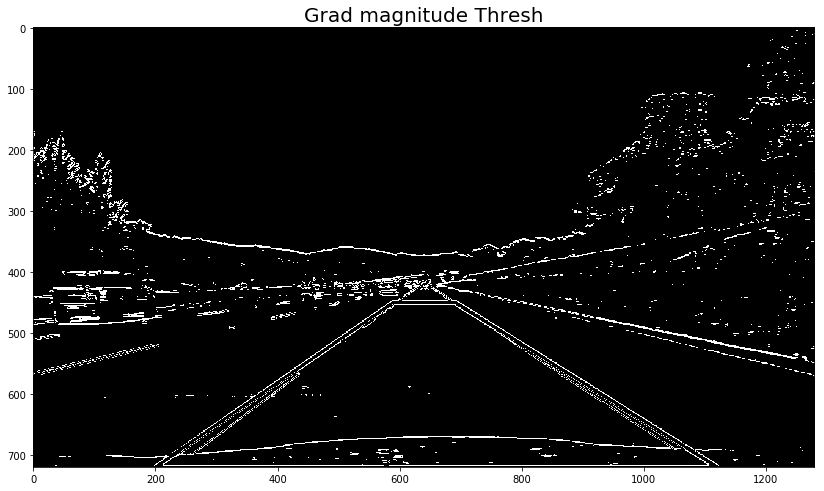

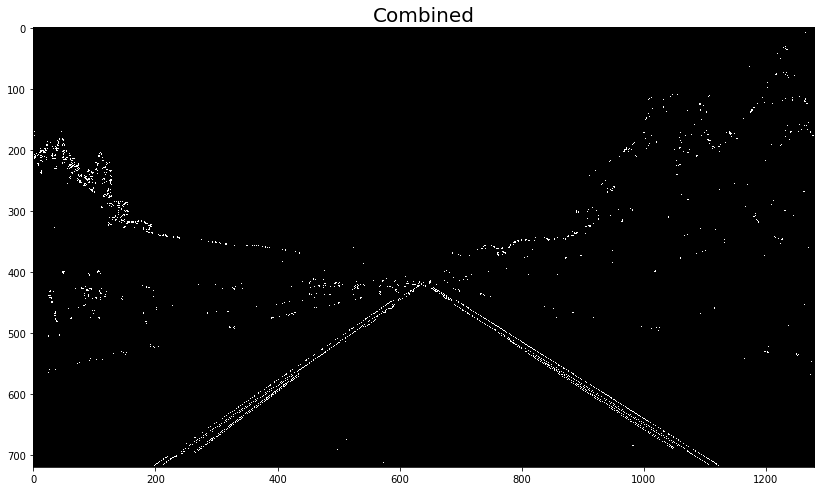

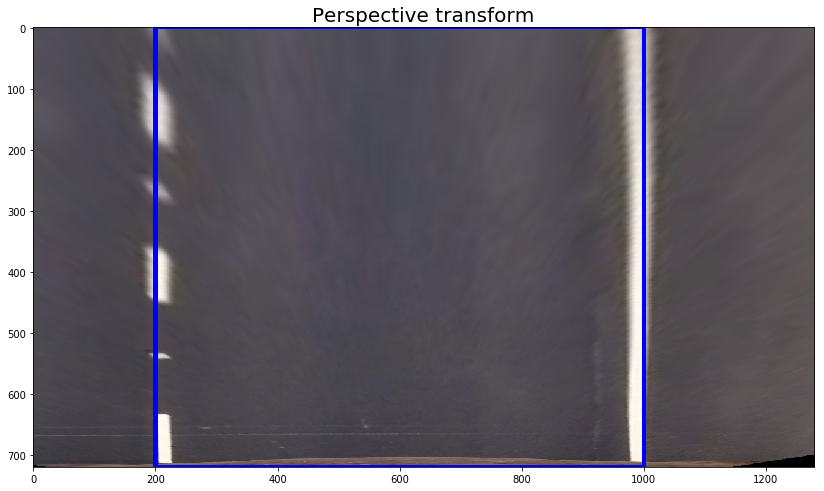

In [109]:
########## JUST FOR MANUAL TESTING
# 2. undistort images
# read the image
test_img_url='./test_images/straight_lines2.jpg'
image = mpimg.imread(test_img_url)
print('Original image: ', test_img_url)
# undistort
undistorted = undistort(image, mtx, dist)
# binary threshold
thresholded = threshold_binary(undistorted, debug=True)
_, _, warped = perspectiveTransform(undistorted, debug=True)
    
# display
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(thresholded)
ax3.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Display sample images showing the functions
undistorted_gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)

abs_sobel_thresh_x = abs_sobel_thresh(undistorted_gray, 'x', sobel_kernel=3, thresh=(30, 100))
abs_sobel_thresh_y = abs_sobel_thresh(undistorted_gray, 'y', sobel_kernel=3, thresh=(30, 100))
mag_thresh = abs_sobel_thresh(undistorted_gray, 'y', sobel_kernel=3, thresh=(30, 100))
# combination
combined = np.zeros_like(mag_thresh)
combined[(abs_sobel_thresh_x==1) & (abs_sobel_thresh_y==1) & (mag_thresh==1)] = 1


plt.figure(figsize=(14,14))
plt.imshow(undistorted)
plt.title('Undistorted Image', fontsize=20)
#
plt.figure(figsize=(14,14))
plt.imshow(abs_sobel_thresh_x, cmap='gray')
plt.title('Sobelx', fontsize=20)
#
plt.figure(figsize=(14,14))
plt.imshow(abs_sobel_thresh_y, cmap='gray')
plt.title('Sobely', fontsize=20)
#
plt.figure(figsize=(14,14))
plt.imshow(mag_thresh, cmap='gray')
plt.title('Grad magnitude Thresh', fontsize=20)
#
plt.figure(figsize=(14,14))
plt.imshow(combined, cmap='gray')
plt.title('Combined', fontsize=20)
#
plt.figure(figsize=(14,14))
plt.imshow(warped)
plt.title('Perspective transform', fontsize=20)